# Filtering based on albedo

In this file we load data which contains all of the points with 2 valid counterfactuals, and select only the ones who have a large enough difference in albedo between the real and counterfactual clouds.

In [1]:
import numpy as np
import pandas as pd
import os
import pathlib
from datetime import datetime, time, timedelta
from scipy import stats
import matplotlib.pyplot as plt
def sem_statistic(data):
    std_val = np.nanstd(data, ddof=1)
    count = np.sum(~np.isnan(data))
    sem_val = std_val / np.sqrt(count)
    return sem_val
Columns_needed_r = pathlib.Path("/gws/nopw/j04/eo_shared_data_vol2/scratch/AO12/Signal&Mass/Real/2019_02_02_00:00")
Columns_needed_f = pathlib.Path("/gws/nopw/j04/eo_shared_data_vol2/scratch/AO12/Signal&Mass/UCF/2019_02_02_00:00")
col_r = pd.read_csv(Columns_needed_r)
col_f = pd.read_csv(Columns_needed_f)

In [2]:
import pandas as pd
from datetime import datetime, timedelta

StartDate = datetime(2019, 1, 1, 0, 0)
EndDate = datetime(2020, 1, 1, 0, 0)

Selected_Real_Sets = []
Selected_CF_Sets = []

while StartDate < EndDate:
    try:
        Link_Real =  '/gws/nopw/j04/eo_shared_data_vol2/scratch/AO12/Signal&Mass/Real/{}_{}_{}_{}:{}'.format(
            str(StartDate.year), str(StartDate.month).zfill(2), str(StartDate.day).zfill(2),
            str(StartDate.hour).zfill(2), str(StartDate.minute).zfill(2))
        Link_Upper = '/gws/nopw/j04/eo_shared_data_vol2/scratch/AO12/Signal&Mass/UCF/{}_{}_{}_{}:{}'.format(
            str(StartDate.year), str(StartDate.month).zfill(2), str(StartDate.day).zfill(2),
            str(StartDate.hour).zfill(2), str(StartDate.minute).zfill(2))
        Link_Lower = '/gws/nopw/j04/eo_shared_data_vol2/scratch/AO12/Signal&Mass/LCF/{}_{}_{}_{}:{}'.format(
            str(StartDate.year), str(StartDate.month).zfill(2), str(StartDate.day).zfill(2),
            str(StartDate.hour).zfill(2), str(StartDate.minute).zfill(2))
        
        Real = pd.read_csv(Link_Real)
        UCF_file  = pd.read_csv(Link_Upper)
        LCF_file  = pd.read_csv(Link_Lower)
        
        Grouped_Real_Data = Real.groupby('particle')
        Grouped_CFU       = UCF_file.groupby('particle')
        Grouped_CFL       = LCF_file.groupby('particle')
        
        for particle_id, group_real in Grouped_Real_Data:
            if len(group_real) < 5:
                continue
            else:
                group_real.sort_values(by='jday', inplace=True)
                group_cfu = Grouped_CFU.get_group(particle_id).sort_values(by='jday')
                group_cfl = Grouped_CFL.get_group(particle_id).sort_values(by='jday')
                
                threshold_met = False
                for idx, row in group_real.iterrows():
                    if idx >= len(group_cfu) or idx >= len(group_cfl):
                        continue  # Skip if index is out-of-bounds for group_cfu or group_cfl
                    
                    threshold = max(group_cfu['Visible_Albedo'].iloc[idx], group_cfl['Visible_Albedo'].iloc[idx])
                    if row['Visible_Albedo'] > (threshold + 0.05):
                        Selected_Real_Sets.append(group_real)
                        Selected_CF_Sets.append(group_cfu)
                        threshold_met = True
                        break
                
                if threshold_met:
                    break

        StartDate += timedelta(hours=1)
        
    except Exception as e:
      #  print(f'Did not work due to {e}')
        StartDate += timedelta(hours=1)

real_df = pd.concat(Selected_Real_Sets, ignore_index=True)
cf_df = pd.concat(Selected_CF_Sets, ignore_index=True)
print('Finished for 2019')


Finished for 2019


In [3]:
# date = datetime(2019, 1, 1, 0, 0)
# real_df_list = []  # Changed to a list
# cf_df_list = []    # Changed to a list

# while date < datetime(2020, 1, 1, 0, 0):
#     try:
#         real = pathlib.Path(f"/gws/nopw/j04/eo_shared_data_vol2/scratch/AO12/Signal&Mass/Real/{date.year}_{date.month:02d}_{date.day:02d}_{date.hour:02d}:{date.minute:02d}")
#         ucf = pathlib.Path(f"/gws/nopw/j04/eo_shared_data_vol2/scratch/AO12/Signal&Mass/UCF/{date.year}_{date.month:02d}_{date.day:02d}_{date.hour:02d}:{date.minute:02d}")
#         lcf = pathlib.Path(f"/gws/nopw/j04/eo_shared_data_vol2/scratch/AO12/Signal&Mass/LCF/{date.year}_{date.month:02d}_{date.day:02d}_{date.hour:02d}:{date.minute:02d}")
#         REAL = pd.read_csv(real)
#         UCF = pd.read_csv(ucf)
#         LCF = pd.read_csv(lcf)
#         REAL.sort_values(by=['particle', 'jday'], inplace=True)
#         UCF.sort_values(by=['particle', 'jday'], inplace=True)
#         LCF.sort_values(by=['particle', 'jday'], inplace=True)
#         for number in range(len(REAL)):
#             num = int(number)
#             threshold = max(UCF['Visible_Albedo'].iloc[num], LCF['Visible_Albedo'].iloc[num])
#             if (REAL['Visible_Albedo'].iloc[num] - threshold) > 0.05:
#                 real_df_list.append(REAL.iloc[num].to_dict())  # Append row directly
#                 cf_df_list.append(UCF.iloc[num].to_dict())      # Append row directly
#                 cf_df_list.append(LCF.iloc[num].to_dict())    
#         date += timedelta(hours=1)
#     except Exception as e:
#       #  print(f'Did not work due to {e}')
#         date += timedelta(hours=1)

# real_df = pd.DataFrame(real_df_list)
# cf_df = pd.DataFrame(cf_df_list)
# print('Finished loading files for 2019')

In [4]:
len(cf_df) /2

17700.5

In [5]:
time_of_obs_real = pd.to_datetime(real_df["jday"], format='mixed')
timestep_real = np.round(real_df["timestep"] * 4) / 4
time_of_emission_real = time_of_obs_real - timestep_real.astype("timedelta64[h]")
# Fitted
time_of_obs_cf = pd.to_datetime(cf_df["jday"], format='mixed')
timestep_cf = np.round(cf_df["timestep"] * 4) / 4
time_of_emission_cf = time_of_obs_cf - timestep_cf.astype("timedelta64[h]")

In [6]:
# Real
wh_valid_real = np.logical_and.reduce([real_df["cer_uncertainty"] < 10, real_df["cer"] > 0, real_df["cer"] < 40,  real_df["illum"] == 1,
                                       real_df["cot_uncertainty"] < 10, real_df["cot"] > 0, real_df["cot"] < 30, real_df["cwp_uncertainty"] < 10,
                                       real_df["cwp"] > 0, real_df["cwp"] < 100, real_df["cloud_type"] == 3,  real_df["Visible_Albedo"] != np.nan, 
                                       real_df["Albedo_Uncertainty"] != np.nan, real_df['cth'] > 0.5, real_df['cth'] < 2.5,  real_df['cth_uncertainty'] < 2, 
                                       real_df["timestep"] < 24])
# Counterfactuals
wh_valid_cf = np.logical_and.reduce([cf_df["cer_uncertainty"] < 10, cf_df["cer"] > 0, cf_df["cer"] < 40,  cf_df["illum"] ==1 ,
                                       cf_df["cot_uncertainty"] < 10, cf_df["cot"] > 0, cf_df["cot"] < 30, cf_df["cwp_uncertainty"] < 10,
                                       cf_df["cwp"] > 0, cf_df["cwp"] < 100, cf_df["cloud_type"] == 3,  cf_df["Visible_Albedo"] != np.nan, 
                                       cf_df["Albedo_Uncertainty"] != np.nan, cf_df['cth'] > 0.5, cf_df['cth'] < 2.5, cf_df['cth_uncertainty'] < 2, 
                                       cf_df["timestep"] < 24])

In [7]:
cer_bins_real = stats.binned_statistic_2d(
    time_of_emission_real.dt.hour[wh_valid_real], timestep_real[wh_valid_real], real_df["cer"][wh_valid_real], 
    bins=[np.linspace(0,24,25), np.linspace(0,24,25)], 
    statistic=np.nanmean
)
cot_bins_real = stats.binned_statistic_2d(
    time_of_emission_real.dt.hour[wh_valid_real], timestep_real[wh_valid_real], real_df["cot"][wh_valid_real], 
    bins=[np.linspace(0,24,25), np.linspace(0,24,25)], 
    statistic=np.nanmean
)
cwp_bins_real = stats.binned_statistic_2d(
    time_of_emission_real.dt.hour[wh_valid_real], timestep_real[wh_valid_real], real_df["cwp"][wh_valid_real], 
    bins=[np.linspace(0,24,25), np.linspace(0,24,25)], 
    statistic=np.nanmean
)

In [8]:
cer_bins_cf = stats.binned_statistic_2d(
    time_of_emission_cf.dt.hour[wh_valid_cf], timestep_cf[wh_valid_cf], cf_df["cer"][wh_valid_cf], 
    bins=[np.linspace(0,24,25), np.linspace(0,24,25)], 
    statistic=np.nanmean
)

cot_bins_cf = stats.binned_statistic_2d(
    time_of_emission_cf.dt.hour[wh_valid_cf], timestep_cf[wh_valid_cf], cf_df["cot"][wh_valid_cf], 
    bins=[np.linspace(0,24,25), np.linspace(0,24,25)], 
    statistic=np.nanmean
)

cwp_bins_cf = stats.binned_statistic_2d(
    time_of_emission_cf.dt.hour[wh_valid_cf], timestep_cf[wh_valid_cf], cf_df["cwp"][wh_valid_cf], 
    bins=[np.linspace(0,24,25), np.linspace(0,24,25)], 
    statistic=np.nanmean
)

In [9]:
cer_real   = cer_bins_real.statistic
cot_real   = cot_bins_real.statistic
cwp_real   = cwp_bins_real.statistic

cer_cf = cer_bins_cf.statistic
cot_cf = cot_bins_cf.statistic
cwp_cf = cwp_bins_cf.statistic

# np.save("Filtered_Real_cer_array_8hrs", cer_real)
# np.save("Filtered_Real_cot_array_8hrs", cot_real)
# np.save("Filtered_Real_cwp_array_8hrs", cwp_real)

# np.save("Filtered_CF_cer_array_8hrs", cer_real)
# np.save("Filtered_CF_cot_array_8hrs", cot_real)
# np.save("Filtered_CF_cwp_array_8hrs", cwp_real)

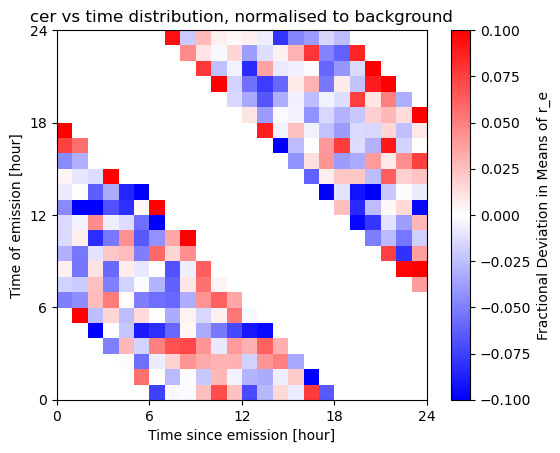

In [10]:
normer = np.ones((24, 24))
signal_cer = cer_real / cer_cf
MYvmax_cer = np.nanmax(np.abs(signal_cer - normer))
MYvmin_cer = -MYvmax_cer
plt.figure()
plt.imshow(signal_cer - normer, extent=(0, 24, 24, 0), cmap='bwr', vmin=-0.1, vmax=0.1)  # Adjust vmin and vmax as needed
plt.colorbar(label="Fractional Deviation in Means of r_e")
plt.xticks(np.linspace(0,24,5))
plt.xlabel("Time since emission [hour]")
plt.yticks(np.linspace(0,24,5))
plt.ylabel("Time of emission [hour]")
plt.title("cer vs time distribution, normalised to background")
plt.gca().invert_yaxis()
#plt.savefig('filtered_cer_2019_heatmap_8hrs', bbox_inches='tight', dpi = 400)
plt.show()

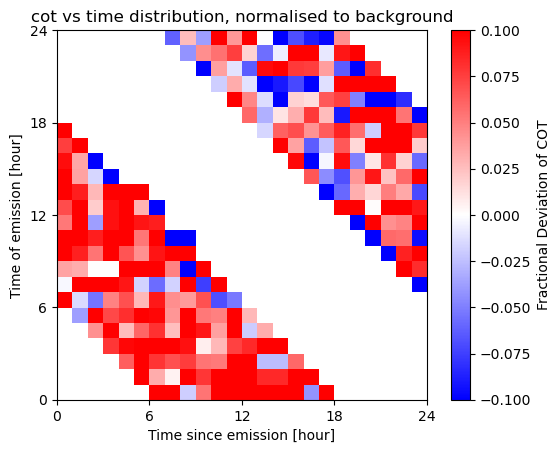

In [11]:
signal_cot = cot_real / cot_cf
MYvmax_cot = np.nanmax(np.abs(signal_cot - normer))
MYvmin_cot = -MYvmax_cot
plt.figure()
plt.imshow(signal_cot - normer, extent=(0, 24, 24, 0), cmap='bwr', vmin=-0.1, vmax=0.1) 
plt.colorbar(label="Fractional Deviation of COT")
plt.xticks(np.linspace(0,24,5))
plt.xlabel("Time since emission [hour]")
plt.yticks(np.linspace(0,24,5))
plt.ylabel("Time of emission [hour]")
plt.gca().invert_yaxis()
plt.title("cot vs time distribution, normalised to background")
#plt.savefig('filtered_cot_2019_heatmap_8hrs', bbox_inches='tight', dpi = 400)
plt.show()

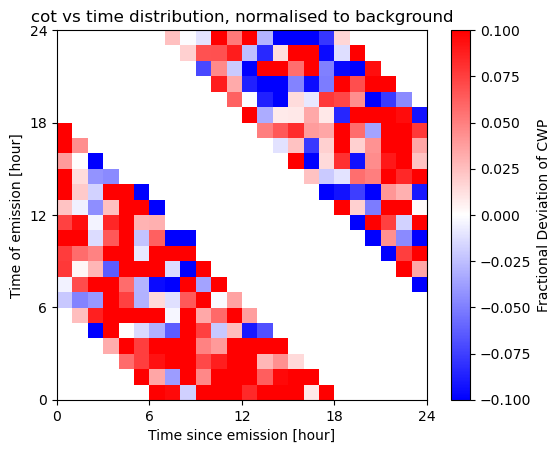

In [12]:
signal_cwp = cwp_real / cwp_cf
MYvmax_cwp = np.nanmax(np.abs(signal_cwp - normer))
MYvmin_cwp = -MYvmax_cwp
plt.figure()
plt.imshow(signal_cwp - normer, extent=(0, 24, 24, 0), cmap='bwr', vmin=-0.1, vmax=0.1) 
plt.colorbar(label="Fractional Deviation of CWP")
plt.xticks(np.linspace(0,24,5))
plt.xlabel("Time since emission [hour]")
plt.yticks(np.linspace(0,24,5))
plt.ylabel("Time of emission [hour]")
plt.gca().invert_yaxis()
plt.title("cot vs time distribution, normalised to background")
#plt.savefig('filtered_cwp_2019_heatmap_8hrs', bbox_inches='tight', dpi = 400)
plt.show()

In [13]:
cer_bins_real_1d = stats.binned_statistic(
    timestep_real[wh_valid_real], real_df["cer"][wh_valid_real], 
    bins = np.linspace(0,24,25),
    statistic = np.nanmean 
)
cer_errors_real_1d = stats.binned_statistic(
    timestep_real[wh_valid_real], real_df["cer"][wh_valid_real], 
    bins = np.linspace(0,24,25),
    statistic = sem_statistic
)

cot_bins_real_1d = stats.binned_statistic(
    timestep_real[wh_valid_real], real_df["cot"][wh_valid_real], 
    bins = np.linspace(0,24,25),
    statistic=np.nanmean
)
cot_errors_real_1d = stats.binned_statistic(
    timestep_real[wh_valid_real], real_df["cot"][wh_valid_real], 
    bins = np.linspace(0,24,25),
    statistic = sem_statistic
)
cwp_bins_real_1d = stats.binned_statistic(
    timestep_real[wh_valid_real], real_df["cwp"][wh_valid_real], 
    bins = np.linspace(0,24,25), 
    statistic=np.nanmean
)
cwp_errors_real_1d = stats.binned_statistic(
    timestep_real[wh_valid_real], real_df["cwp"][wh_valid_real], 
    bins = np.linspace(0,24,25), 
    statistic = sem_statistic
)

In [14]:
cer_bins_cf_1d = stats.binned_statistic(
    timestep_cf[wh_valid_cf], cf_df["cer"][wh_valid_cf], 
    bins=np.linspace(0,24,25), 
    statistic=np.nanmean
)
cer_errors_cf_1d = stats.binned_statistic(
    timestep_cf[wh_valid_cf], cf_df["cer"][wh_valid_cf], 
    bins=np.linspace(0,24,25), 
    statistic = sem_statistic
)

cot_bins_cf_1d = stats.binned_statistic(
    timestep_cf[wh_valid_cf], cf_df["cot"][wh_valid_cf], 
    bins=np.linspace(0,24,25), 
    statistic=np.nanmean
)
cot_errors_cf_1d = stats.binned_statistic(
    timestep_cf[wh_valid_cf], cf_df["cot"][wh_valid_cf], 
    bins=np.linspace(0,24,25), 
    statistic = sem_statistic
)
cwp_bins_cf_1d = stats.binned_statistic(
    timestep_cf[wh_valid_cf], cf_df["cwp"][wh_valid_cf], 
    bins=np.linspace(0,24,25), 
    statistic=np.nanmean
)
cwp_errors_cf_1d = stats.binned_statistic(
    timestep_cf[wh_valid_cf], cf_df["cwp"][wh_valid_cf], 
    bins=np.linspace(0,24,25), 
    statistic = sem_statistic
)

In [15]:
cer_real_1d   = cer_bins_real_1d.statistic
cot_real_1d   = cot_bins_real_1d.statistic
cwp_real_1d   = cwp_bins_real_1d.statistic
cer_real_errors_1d   = cer_errors_real_1d.statistic
cot_real_errors_1d   = cot_errors_real_1d.statistic
cwp_real_errors_1d   = cwp_errors_real_1d.statistic

cer_cf_1d = cer_bins_cf_1d.statistic
cot_cf_1d = cot_bins_cf_1d.statistic
cwp_cf_1d = cwp_bins_cf_1d.statistic
cer_cf_errors_1d = cer_errors_cf_1d.statistic
cot_cf_errors_1d = cot_errors_cf_1d.statistic
cwp_cf_errors_1d = cwp_errors_cf_1d.statistic

# np.save("filtered_cer_vs_time_real_8hrs", cer_real_1d)
# np.save("filtered_cer_vs_time_errors_real_8hrs", cer_real_errors_1d)
# np.save("filtered_cot_vs_time_real_8hrs", cot_real_1d)
# np.save("filtered_cot_vs_time_errors_real_8hrs", cot_real_errors_1d)
# np.save("filtered_cwp_vs_time_real_8hrs", cwp_real_1d)
# np.save("filtered_cwp_vs_time_errors_real_8hrs", cwp_real_errors_1d)

# np.save("filtered_cer_vs_time_cf_8hrs", cer_cf_1d)
# np.save("filtered_cer_vs_time_errors_cf_8hrs", cer_cf_errors_1d)
# np.save("filtered_cer_vs_time_cf_8hrs", cot_cf_1d)
# np.save("filtered_cer_vs_time_errors_cf_8hrs", cot_cf_errors_1d)
# np.save("filtered_cer_vs_time_cf_8hrs", cwp_cf_1d)
# np.save("filtered_cer_vs_time_errors_cf_8hrs", cwp_cf_errors_1d)

# In[ ]:


# Normalising to signal
cer_signal = (cer_real_1d - cer_cf_1d) 
cwp_signal = (cwp_real_1d - cwp_cf_1d) 
cot_signal = (cot_real_1d - cot_cf_1d) 
# Errors 
cer_error_vector = np.sqrt(cer_real_errors_1d ** 2 + cer_cf_errors_1d ** 2)
cwp_error_vector = np.sqrt(cwp_real_errors_1d ** 2 + cwp_cf_errors_1d ** 2)
cot_error_vector = np.sqrt(cot_real_errors_1d ** 2 + cot_cf_errors_1d ** 2)


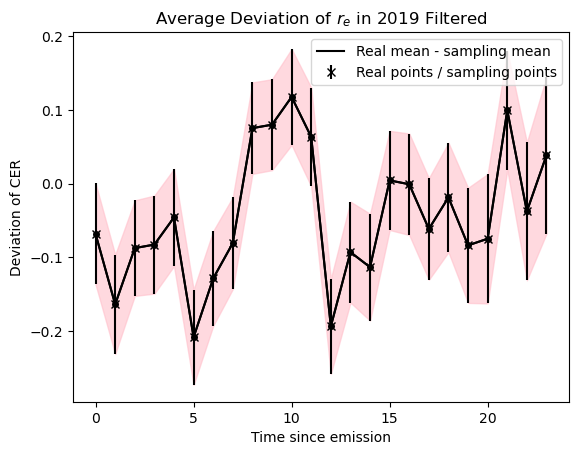

In [16]:
plt.errorbar(range(len(cer_signal)), cer_signal, yerr=cer_error_vector, fmt='x', color='black', label='Real points / sampling points')
plt.plot(range(len(cer_signal)), cer_signal, color='black', linestyle='-', marker='o', markersize=4)
plt.fill_between(range(len(cer_signal)), cer_signal - cer_error_vector, cer_signal + cer_error_vector, color='pink', alpha=0.6)
plt.plot(cer_signal, color='black', label='Real mean - sampling mean')
plt.xlabel('Time since emission')
plt.ylabel('Deviation of CER')
plt.title('Average Deviation of $r_{e}$ in 2019 Filtered')
plt.legend()
#plt.savefig('cer_vs_time_filtered_8hrs', bbox_inches='tight', dpi = 400)
plt.show()


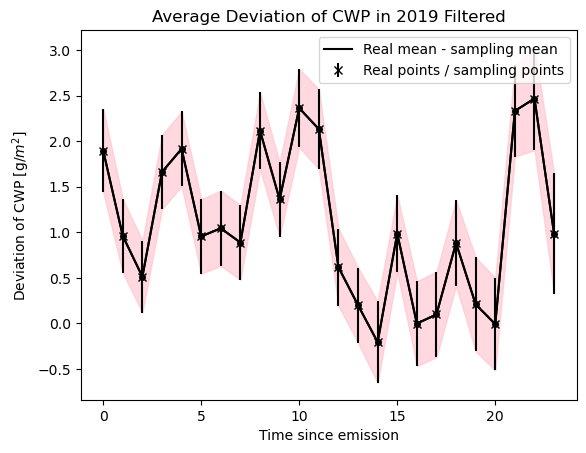

In [17]:
plt.errorbar(range(len(cwp_signal)), cwp_signal, yerr=cwp_error_vector, fmt='x', color='black', label='Real points / sampling points')
plt.plot(range(len(cwp_signal)), cwp_signal, color='black', linestyle='-', marker='o', markersize=4)
plt.fill_between(range(len(cwp_signal)), cwp_signal - cwp_error_vector, cwp_signal + cwp_error_vector, color='pink', alpha=0.6)
plt.plot(cwp_signal, color='black', label='Real mean - sampling mean')
plt.xlabel('Time since emission')
plt.ylabel('Deviation of CWP [g/$m^{2}$]')
plt.title('Average Deviation of CWP in 2019 Filtered')
plt.legend()
#plt.savefig('cwp_vs_time_filtered_8hrs', bbox_inches='tight', dpi = 400)
plt.show()

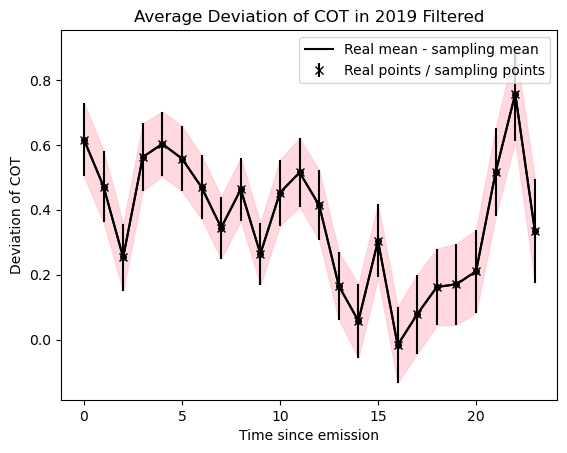

In [18]:
plt.errorbar(range(len(cot_signal)), cot_signal, yerr=cot_error_vector, fmt='x', color='black', label='Real points / sampling points')
plt.plot(range(len(cot_signal)), cot_signal, color='black', linestyle='-', marker='o', markersize=4)
plt.fill_between(range(len(cot_signal)), cot_signal - cot_error_vector, cot_signal + cot_error_vector, color='pink', alpha=0.6)
plt.plot(cot_signal, color='black', label='Real mean - sampling mean')
plt.xlabel('Time since emission')
plt.ylabel('Deviation of COT')
plt.title('Average Deviation of COT in 2019 Filtered')
plt.legend()
#plt.savefig('cot_vs_time_filtered_8hrs', bbox_inches='tight', dpi = 400)
plt.show()

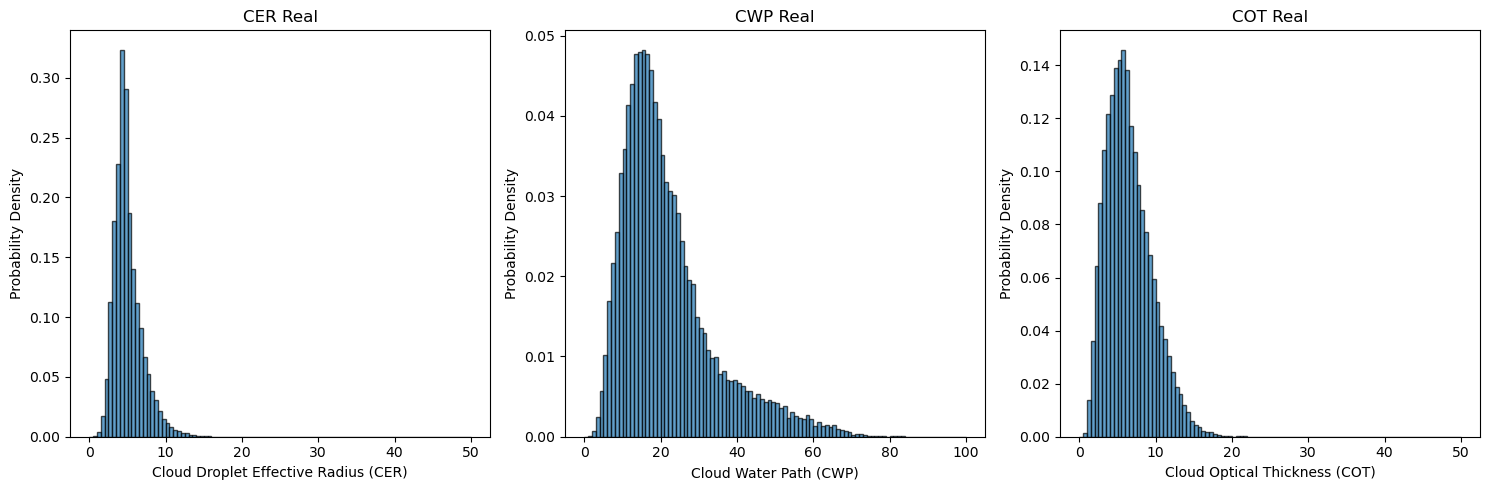

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for 'cer'
cer_data = real_df["cer"][wh_valid_real]
axs[0].hist(cer_data, bins=np.linspace(0, 50, 101), density=True, edgecolor='black', alpha=0.7)
axs[0].set_title('CER Real')
axs[0].set_xlabel('Cloud Droplet Effective Radius (CER)')
axs[0].set_ylabel('Probability Density')

# Plot for 'cwp'
cwp_data = real_df["cwp"][wh_valid_real]
axs[1].hist(cwp_data, bins=np.linspace(0, 100, 101), density=True, edgecolor='black', alpha=0.7)
axs[1].set_title('CWP Real')
axs[1].set_xlabel('Cloud Water Path (CWP)')
axs[1].set_ylabel('Probability Density')

# Plot for 'cot'
cot_data = real_df["cot"][wh_valid_real]
axs[2].hist(cot_data, bins=np.linspace(0, 50, 101), density=True, edgecolor='black', alpha=0.7)
axs[2].set_title('COT Real')
axs[2].set_xlabel('Cloud Optical Thickness (COT)')
axs[2].set_ylabel('Probability Density')

plt.tight_layout()
#plt.savefig("Real_cloud_properties_2019_filtered_8hrs", bbox_inches = 'tight', dpi = 400) 
plt.show()

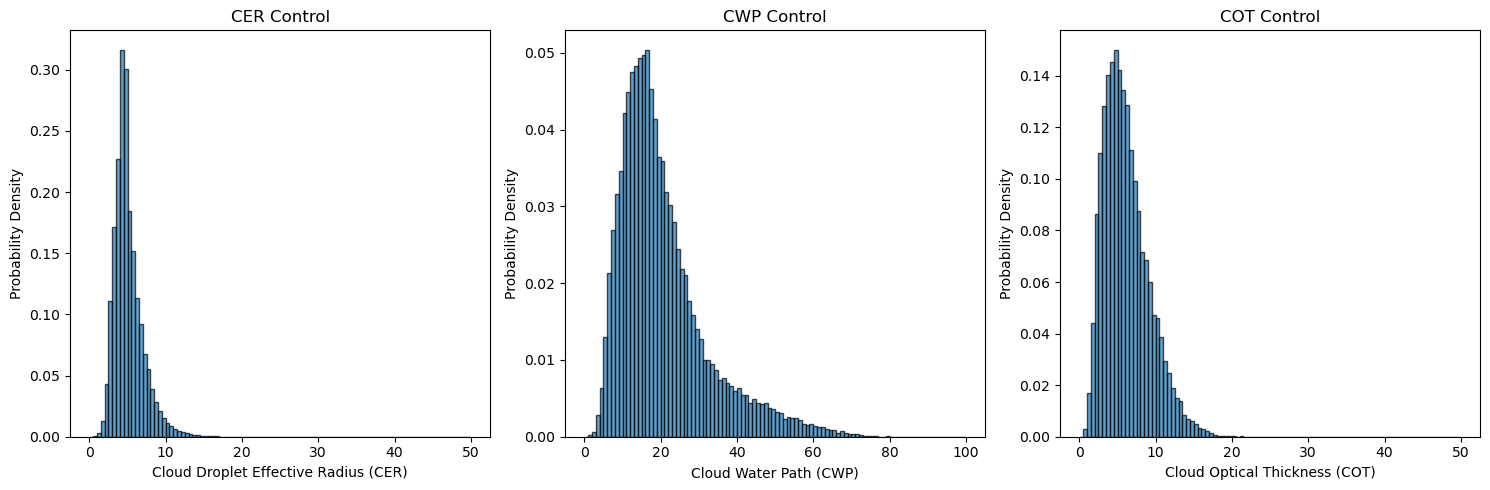

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for 'cer'
cer_data_cf = cf_df["cer"][wh_valid_cf]
axs[0].hist(cer_data_cf, bins=np.linspace(0, 50, 101), density=True, edgecolor='black', alpha=0.7)
axs[0].set_title('CER Control')
axs[0].set_xlabel('Cloud Droplet Effective Radius (CER)')
axs[0].set_ylabel('Probability Density')

# Plot for 'cwp'
cwp_data_cf = cf_df["cwp"][wh_valid_cf]
axs[1].hist(cwp_data_cf, bins=np.linspace(0, 100, 101), density=True, edgecolor='black', alpha=0.7)
axs[1].set_title('CWP Control')
axs[1].set_xlabel('Cloud Water Path (CWP)')
axs[1].set_ylabel('Probability Density')

# Plot for 'cot'
cot_data_cf = cf_df["cot"][wh_valid_cf]
axs[2].hist(cot_data_cf, bins=np.linspace(0, 50, 101), density=True, edgecolor='black', alpha=0.7)
axs[2].set_title('COT Control')
axs[2].set_xlabel('Cloud Optical Thickness (COT)')
axs[2].set_ylabel('Probability Density')

plt.tight_layout()
#plt.savefig("Sample_cloud_properties_2019_filtered_8hrs", bbox_inches = 'tight', dpi = 400) 
plt.show()

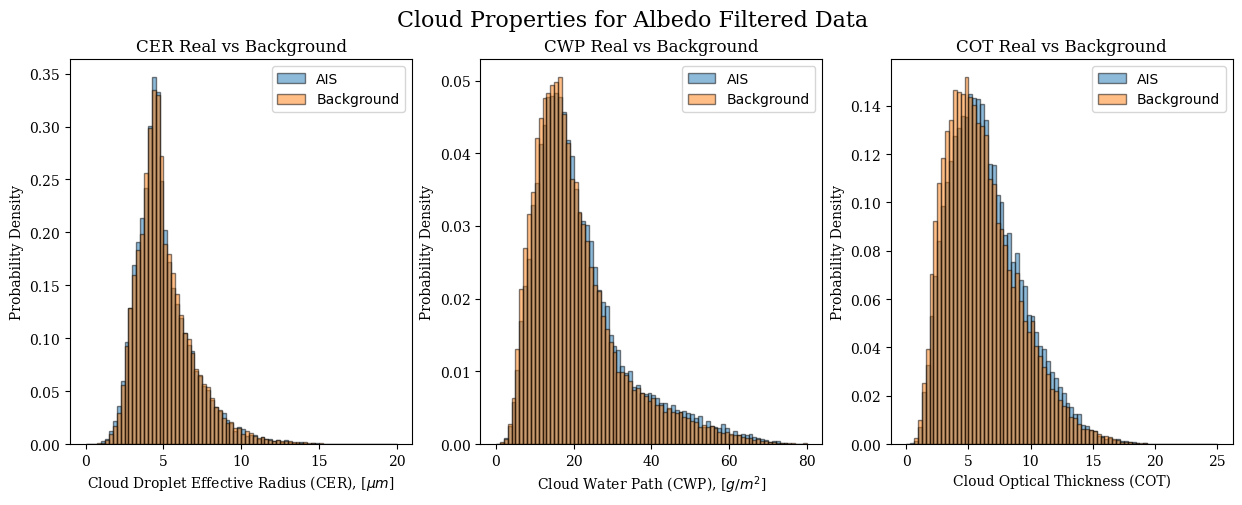

In [21]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs_real = plt.subplots(1, 3, figsize=(15, 5))

# Plot 'cer' on the existing subplot
n_cer, bins_cer, _ = axs_real[0].hist(cer_data, bins=np.linspace(0, 20, 81), density=True, edgecolor='black', alpha=0.5, label='AIS')
n_cer_cf, bins_cer_cf, _ = axs_real[0].hist(cer_data_cf, bins=np.linspace(0, 20, 81), density=True, edgecolor='black', alpha=0.5, label='Background')
axs_real[0].set_title('CER Real vs Background')
axs_real[0].set_xlabel('Cloud Droplet Effective Radius (CER), [$\mu m$]')
axs_real[0].set_ylabel('Probability Density')
axs_real[0].legend()

# Calculate means and standard deviations for cer_data and cer_data_cf
mean_cer = np.mean(cer_data)
std_cer = np.std(cer_data)
mean_cer_cf = np.mean(cer_data_cf)
std_cer_cf = np.std(cer_data_cf)

# Annotate means and standard deviations on the plot (below the legend)
#axs_real[0].text(0.98, 0.85, f'Mean AIS: {mean_cer:.2f}, Std AIS: {std_cer:.2f}', transform=axs_real[0].transAxes, verticalalignment='top', horizontalalignment='right')
#axs_real[0].text(0.98, 0.8, f'Mean Background: {mean_cer_cf:.2f}, Std Background: {std_cer_cf:.2f}', transform=axs_real[0].transAxes, verticalalignment='top', horizontalalignment='right')

# Plot 'cwp' on the existing subplot
n_cwp, bins_cwp, _ = axs_real[1].hist(cwp_data, bins=np.linspace(0, 80, 81), density=True, edgecolor='black', alpha=0.5, label='AIS')
n_cwp_cf, bins_cwp_cf, _ = axs_real[1].hist(cwp_data_cf, bins=np.linspace(0, 80, 81), density=True, edgecolor='black', alpha=0.5, label='Background')
axs_real[1].set_title('CWP Real vs Background')
axs_real[1].set_xlabel('Cloud Water Path (CWP), [$g/m^{2}$]')
axs_real[1].set_ylabel('Probability Density')
axs_real[1].legend()

# Calculate means and standard deviations for cwp_data and cwp_data_cf
mean_cwp = np.mean(cwp_data)
std_cwp = np.std(cwp_data)
mean_cwp_cf = np.mean(cwp_data_cf)
std_cwp_cf = np.std(cwp_data_cf)

# Annotate means and standard deviations on the plot (below the legend)
#axs_real[1].text(0.98, 0.85, f'Mean AIS: {mean_cwp:.2f}, Std AIS: {std_cwp:.2f}', transform=axs_real[1].transAxes, verticalalignment='top', horizontalalignment='right')
#axs_real[1].text(0.98, 0.8, f'Mean Background: {mean_cwp_cf:.2f}, Std Background: {std_cwp_cf:.2f}', transform=axs_real[1].transAxes, verticalalignment='top', horizontalalignment='right')

# Plot 'cot' on the existing subplot
n_cot, bins_cot, _ = axs_real[2].hist(cot_data, bins=np.linspace(0, 25, 81), density=True,  edgecolor='black', alpha=0.5, label='AIS')
n_cot_cf, bins_cot_cf, _ = axs_real[2].hist(cot_data_cf, bins=np.linspace(0, 25, 81), density=True, edgecolor='black', alpha=0.5, label='Background')
axs_real[2].set_title('COT Real vs Background')
axs_real[2].set_xlabel('Cloud Optical Thickness (COT)')
axs_real[2].set_ylabel('Probability Density')
axs_real[2].legend()

# Calculate means and standard deviations for cot_data and cot_data_cf
mean_cot = np.mean(cot_data)
std_cot = np.std(cot_data)
mean_cot_cf = np.mean(cot_data_cf)
std_cot_cf = np.std(cot_data_cf)

# Annotate means and standard deviations on the plot (below the legend)
#axs_real[2].text(0.98, 0.85, f'Mean AIS: {mean_cot:.2f}, Std AIS: {std_cot:.2f}', transform=axs_real[2].transAxes, verticalalignment='top', horizontalalignment='right')
#axs_real[2].text(0.98, 0.8, f'Mean Background: {mean_cot_cf:.2f}, Std Background: {std_cot_cf:.2f}', transform=axs_real[2].transAxes, verticalalignment='top', horizontalalignment='right')

#plt.tight_layout()
#plt.savefig("Sample_vs_real_cloud_properties_2019_filtered_8hrs", bbox_inches = 'tight', dpi = 400) 
#plt.suptitle('Main Title', fontsize=16)
plt.suptitle('Cloud Properties for Albedo Filtered Data', fontsize=16, font = 'serif')
for i in range(3):
    for item in ([axs_real[i].title, axs_real[i].xaxis.label, axs_real[i].yaxis.label] +
        axs_real[i].get_xticklabels() + axs_real[i].get_yticklabels()):
        item.set_fontname('serif')
plt.show()


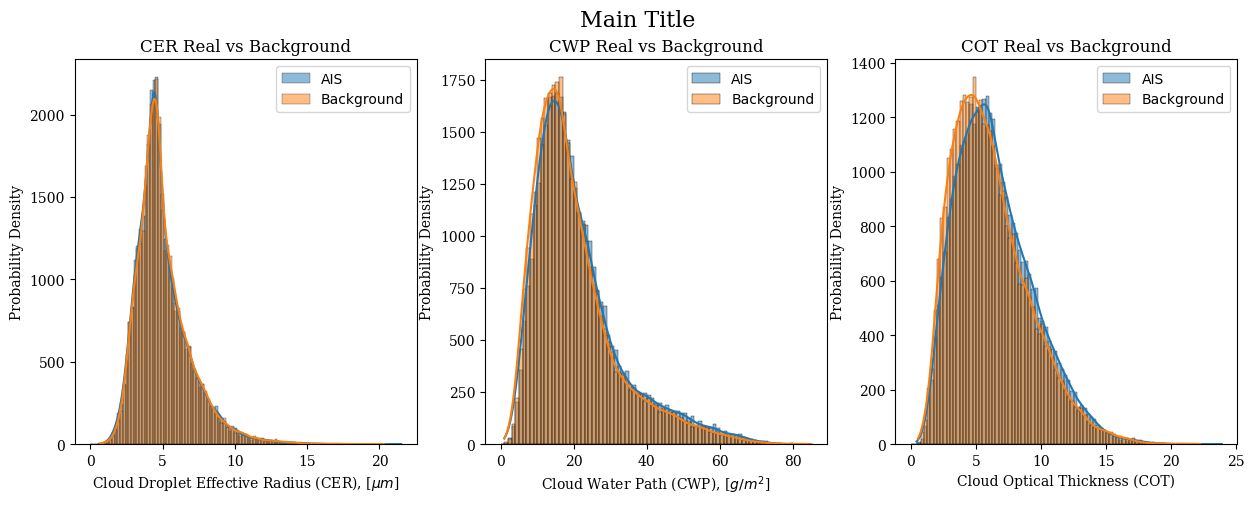

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs_real = plt.subplots(1, 3, figsize=(15, 5))

# Plot 'cer' on the existing subplot with Seaborn
sns.histplot(cer_data, bins=np.linspace(0, 15, 81), kde = True, edgecolor='black', alpha=0.5, label='AIS', ax=axs_real[0])
sns.histplot(cer_data_cf, bins=np.linspace(0, 15, 81), kde = True, edgecolor='black', alpha=0.5, label='Background', ax=axs_real[0])
axs_real[0].set_title('CER Real vs Background')
axs_real[0].set_xlabel('Cloud Droplet Effective Radius (CER), [$\mu m$]')
axs_real[0].set_ylabel('Probability Density')
axs_real[0].legend()

# Plot 'cwp' on the existing subplot with Seaborn
sns.histplot(cwp_data, bins=np.linspace(0, 80, 81), kde = True, edgecolor='black', alpha=0.5, label='AIS', ax=axs_real[1])
sns.histplot(cwp_data_cf, bins=np.linspace(0, 80, 81), kde = True, edgecolor='black', alpha=0.5, label='Background', ax=axs_real[1])
axs_real[1].set_title('CWP Real vs Background')
axs_real[1].set_xlabel('Cloud Water Path (CWP), [$g/m^{2}$]')
axs_real[1].set_ylabel('Probability Density')
axs_real[1].legend()

# Plot 'cot' on the existing subplot with Seaborn
sns.histplot(cot_data, bins=np.linspace(0, 20, 81), kde = True, edgecolor='black', alpha=0.5, label='AIS', ax=axs_real[2])
sns.histplot(cot_data_cf, bins=np.linspace(0, 20, 81), kde = True, edgecolor='black', alpha=0.5, label='Background', ax=axs_real[2])
axs_real[2].set_title('COT Real vs Background')
axs_real[2].set_xlabel('Cloud Optical Thickness (COT)')
axs_real[2].set_ylabel('Probability Density')
axs_real[2].legend()


# Set main title
plt.suptitle('Main Title', fontsize=16, font = 'serif')
for i in range(3):
    for item in ([axs_real[i].title, axs_real[i].xaxis.label, axs_real[i].yaxis.label] +
        axs_real[i].get_xticklabels() + axs_real[i].get_yticklabels()):
        item.set_fontname('serif')
plt.show()


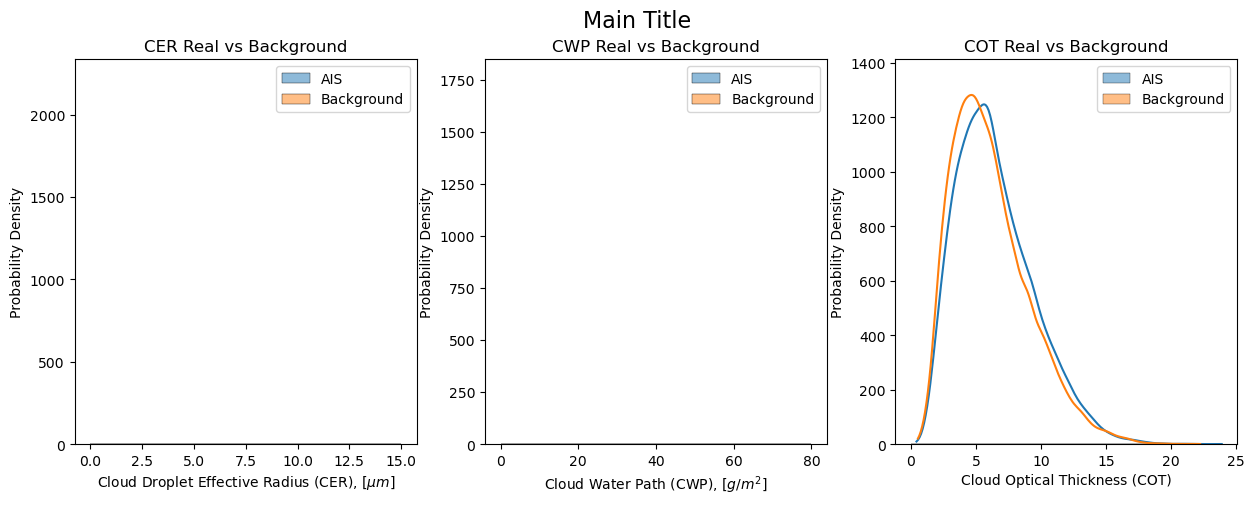

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs_real = plt.subplots(1, 3, figsize=(15, 5))

# Define the number of bins and their ranges
cer_bins = np.linspace(0, 15, 81)
cwp_bins = np.linspace(0, 80, 81)
cot_bins = np.linspace(0, 20, 81)

# Plot 'cer' on the existing subplot with Seaborn
sns.histplot(cer_data, bins=cer_bins, edgecolor='black', alpha=0.5, label='AIS', ax=axs_real[0])#, palette='viridis')
sns.histplot(cer_data_cf, bins=cer_bins, edgecolor='black', alpha=0.5, label='Background', ax=axs_real[0])#, palette='inferno')
axs_real[0].set_title('CER Real vs Background')
axs_real[0].set_xlabel('Cloud Droplet Effective Radius (CER), [$\mu m$]')
axs_real[0].set_ylabel('Probability Density')
axs_real[0].legend()

# Plot 'cwp' on the existing subplot with Seaborn
sns.histplot(cwp_data, bins=cwp_bins, edgecolor='black', alpha=0.5, label='AIS', ax=axs_real[1])#, palette='plasma')
sns.histplot(cwp_data_cf, bins=cwp_bins, edgecolor='black', alpha=0.5, label='Background', ax=axs_real[1])#, palette='magma')
axs_real[1].set_title('CWP Real vs Background')
axs_real[1].set_xlabel('Cloud Water Path (CWP), [$g/m^{2}$]')
axs_real[1].set_ylabel('Probability Density')
axs_real[1].legend()

# Plot 'cot' on the existing subplot with Seaborn
sns.histplot(cot_data, bins=cot_bins, kde=True, edgecolor='black', alpha=0.5, label='AIS', ax=axs_real[2])#, palette='viridis')
sns.histplot(cot_data_cf, bins=cot_bins, kde=True, edgecolor='black', alpha=0.5, label='Background', ax=axs_real[2])#, palette='inferno')
axs_real[2].set_title('COT Real vs Background')
axs_real[2].set_xlabel('Cloud Optical Thickness (COT)')
axs_real[2].set_ylabel('Probability Density')
axs_real[2].legend()

# Normalize histograms to ensure area under the curve = 1
for ax in axs_real:
    for patch in ax.patches:
        patch.set_height(patch.get_height() / (len(cer_data) + len(cer_data_cf)))

# Set main title
plt.suptitle('Main Title', fontsize=16)

plt.show()


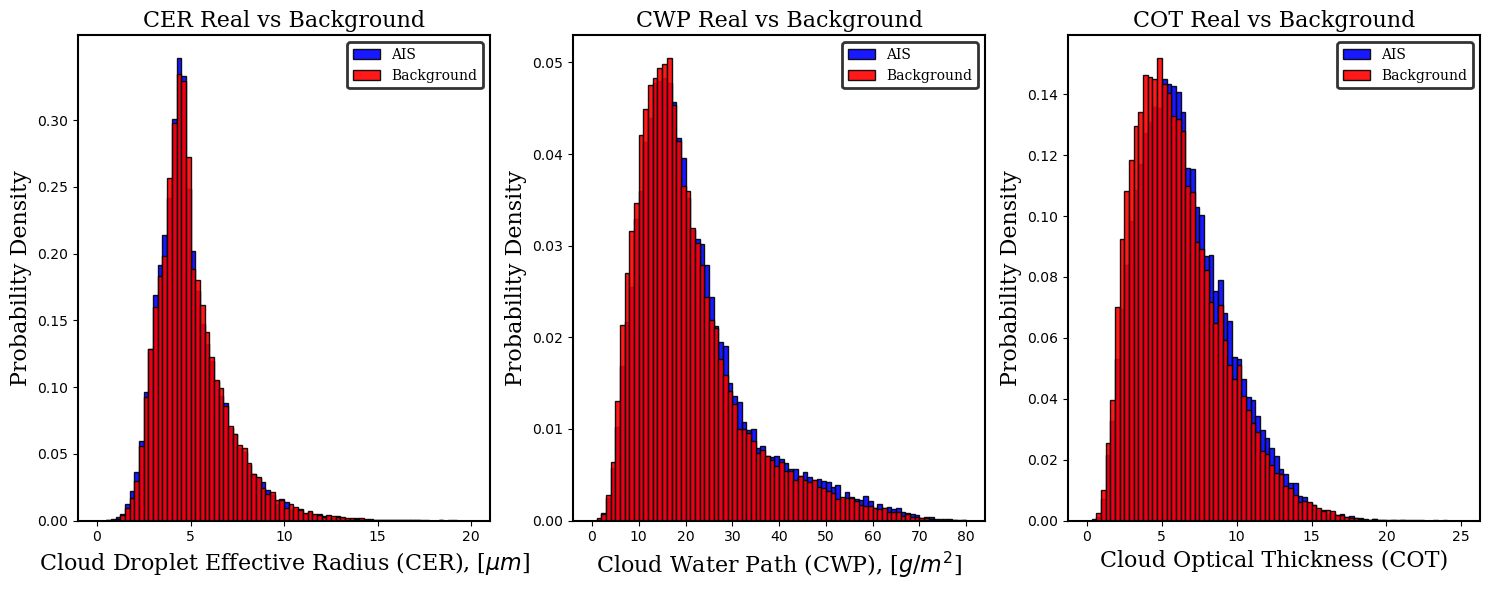

In [24]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs_real = plt.subplots(1, 3, figsize=(15, 6))
c1 = 'blue'
c2 = 'red'
# Plot 'cer' on the existing subplot
n_cer, bins_cer, _ = axs_real[0].hist(cer_data, bins=np.linspace(0, 20, 81), density=True, color=c1, edgecolor='black', alpha=0.9, label='AIS')
n_cer_cf, bins_cer_cf, _ = axs_real[0].hist(cer_data_cf, bins=np.linspace(0, 20, 81), density=True, color=c2, edgecolor='black', alpha=0.9, label='Background')
axs_real[0].set_title('CER Real vs Background', fontname='serif', fontsize=16)
axs_real[0].set_xlabel('Cloud Droplet Effective Radius (CER), [$\mu m$]', fontname='serif', fontsize=16)
axs_real[0].set_ylabel('Probability Density', fontname='serif', fontsize=16)
axs_real[0].set_xticks([0, 5, 10, 15, 20])
axs_real[0].set_yticks([0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30], fontname='serif', fontsize=12, color='black')
legend0 = axs_real[0].legend(prop={'family': 'serif'}, fontsize=12)

# Plot 'cwp' on the existing subplot
n_cwp, bins_cwp, _ = axs_real[1].hist(cwp_data, bins=np.linspace(0, 80, 81), density=True, color=c1, edgecolor='black', alpha=0.9, label='AIS')
n_cwp_cf, bins_cwp_cf, _ = axs_real[1].hist(cwp_data_cf, bins=np.linspace(0, 80, 81), density=True, color=c2, edgecolor='black', alpha=0.9, label='Background')
axs_real[1].set_title('CWP Real vs Background', fontname='serif', fontsize=16)
axs_real[1].set_xlabel('Cloud Water Path (CWP), [$g/m^{2}$]', fontname='serif', fontsize=16)
axs_real[1].set_ylabel('Probability Density', fontname='serif', fontsize=16)
legend1 = axs_real[1].legend(prop={'family': 'serif'}, fontsize=12)

# Plot 'cot' on the existing subplot
n_cot, bins_cot, _ = axs_real[2].hist(cot_data, bins=np.linspace(0, 25, 81), density=True, color=c1, edgecolor='black', alpha=0.9, label='AIS')
n_cot_cf, bins_cot_cf, _ = axs_real[2].hist(cot_data_cf, bins=np.linspace(0, 25, 81), density=True, color=c2, edgecolor='black', alpha=0.9, label='Background')
axs_real[2].set_title('COT Real vs Background', fontname='serif', fontsize=16)
axs_real[2].set_xlabel('Cloud Optical Thickness (COT)', fontname='serif', fontsize=16)
axs_real[2].set_ylabel('Probability Density', fontname='serif', fontsize=16)
legend2 = axs_real[2].legend(prop={'family': 'serif'}, fontsize=12)

# Adjusting the border thickness for all subplots
for ax in axs_real:
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)

# Adding a black box around each legend
for legend in [legend0, legend1, legend2]:
    frame = legend.get_frame()
    frame.set_edgecolor('black')
    frame.set_linewidth(2)  # Adjust the thickness of the legend box border

plt.tight_layout()
plt.savefig('Albedo_final', bbox_inches = 'tight', dpi = 500)
plt.show()
